# 02 Features
---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.patches as mpatches    
import warnings
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy as sp
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from tqdm import tqdm
warnings.filterwarnings('ignore')

seed = 0

In [2]:
df=pd.read_excel("df_01.xlsx", index_col=0)
df_test=pd.read_excel("df_test_01.xlsx", index_col=0)

target = 'alcopops'

In [3]:
# drop na in target
df = df[pd.notnull(df[target])]
df_test = df_test[pd.notnull(df_test[target])]

In [4]:
print('Trainning shape:\t',df.shape)
print('Testing shape:\t\t',df_test.shape)

Trainning shape:	 (209, 20)
Testing shape:		 (23, 20)


In [5]:
df.head(1)

,gender,smoking,first_drunk,been_drunk,canabis,exercise,family_well,life_sas,school_achieve,sex,talk_mother,talk_father,evenings,year_collect,gdp_pcapita,urban_pop,teen_preg,out_school,educ_expense,alcopops
203,0,9.8,23.3,18.1,21.5,36.4,3.633,7.36,62.6,18.2,81.5,49.9,20.8,2010,11326.219475,67.841,16.437,0.78639,5.08098,7.2


# 1. Dealing with Missings

In [6]:
def impute_train_missings(train, test,target, verbose = False):
    
    train = df.drop(columns = target).copy()
    train_no_nulls = train.dropna()
    train_with_nulls = train[train.isnull().any(axis=1)]
    
    test_ = test.drop(columns = target)
    
    cv_scorings = pd.DataFrame()
    scaler = MinMaxScaler()

    models = [ExtraTreesRegressor(random_state=seed),
              BayesianRidge(),
              DecisionTreeRegressor(random_state=seed),
              KNeighborsRegressor()]
    
    models_names = [model.__class__.__name__ for model in models]
    mod_dict = dict(zip(models_names,models))
    
    # cols that have missing
    train_null_col = train.columns[train.isna().any()].tolist()
    test_null_col = test_.columns[test_.isna().any()].tolist()
    null_columns = list(set(train_null_col + test_null_col))
    
    entries = []
    
    best_metric_dict = {}
    #for col in tqdm(null_columns):        
    for col in tqdm(null_columns):  
        # slice with nulls
        #test_null -> tmp_null
        tmp_null = train_with_nulls.loc[train_with_nulls[col].isnull()].drop(columns = null_columns)
        tmp_null = tmp_null.dropna(axis=1)

        best_error = -np.inf
        best_metric = None
        best_model_name = None

        x_ = train_no_nulls.drop(columns=null_columns)
        y_ = train_no_nulls[col]
        x_ = scaler.fit_transform(x_)
        x_t_ = scaler.transform(tmp_null)  
        
        for mod_name, model in mod_dict.items():

            model.fit(x_, y_)  
            sqr_err = model_selection.cross_val_score(model, x_, y_, scoring='neg_mean_squared_error', cv = 50)
            for fold_idx, error in enumerate(sqr_err):
                entries.append((fold_idx, col, mod_name, error))

            if sqr_err.mean() > best_error:
                best_metric = model
                best_model_name = mod_name
                best_error = sqr_err.mean()

        if verbose:
            best_metric_dict[col] = best_model_name
            #print(col,'\tBest metric:',best_model_name)
            #print(col,'\tBest error:',best_error)
        
        # predict train
        prediction = best_metric.predict(x_t_)         
        train_with_nulls.loc[train_with_nulls[col].isnull(), col] = prediction
        
        # predict test
        if col in test_null_col:
            tmp_test = test_.loc[test_[col].isnull()].drop(columns = null_columns)
            x_test = scaler.transform(tmp_test)
            prediction_test = best_metric.predict(x_test)
            test_.loc[test_[col].isnull(), col] = prediction_test
         
    train_imputed = pd.concat([train_with_nulls, train_no_nulls] )  
    #print(pd.DataFrame(best_metric_dict.items(), columns = ['feature','best_impute_metric']))
    
    cv_df = pd.DataFrame(entries, columns=['fold_idx', 'variable', 'model_name', 'error'])
    cv_df_grouped = pd.DataFrame(cv_df.groupby(['variable','model_name'])['error'].agg('mean'))
    return train_imputed, test_,cv_df, cv_df_grouped


In [7]:
impute_df, impute_test,cv_df, cv_df_grouped = impute_train_missings(df, df_test ,target, verbose =True)

100%|██████████| 11/11 [00:20<00:00,  2.08s/it]


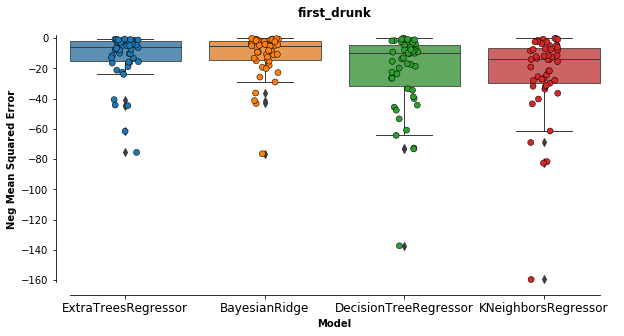

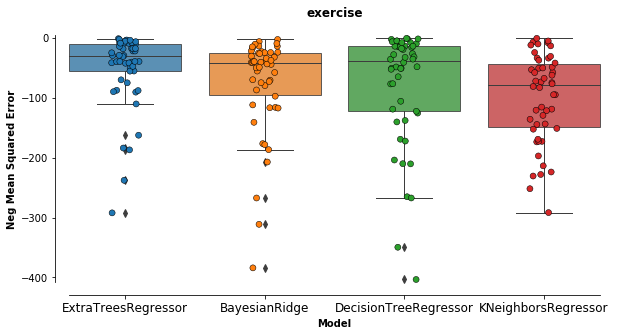

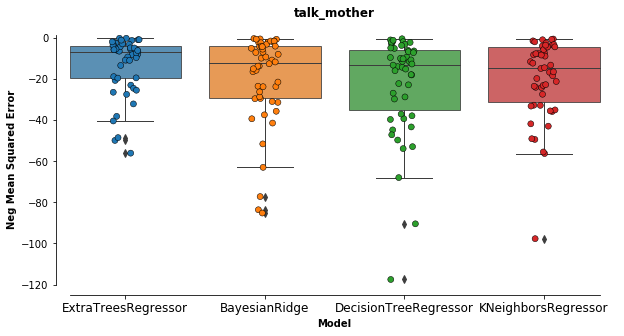

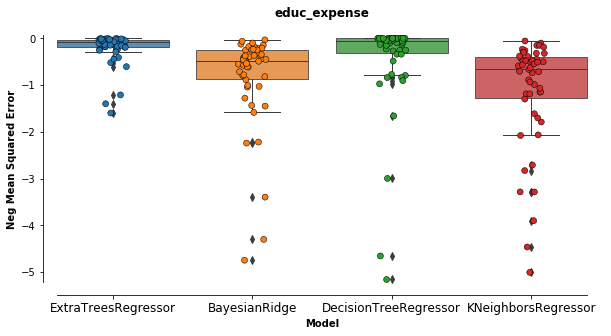

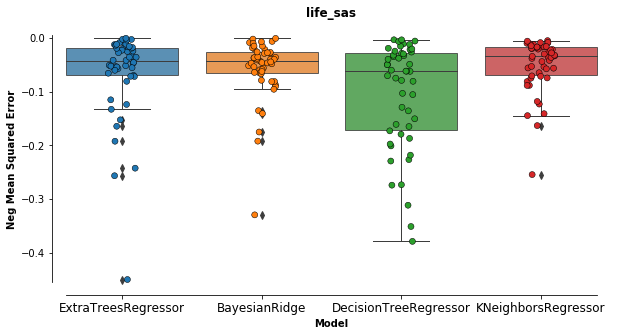

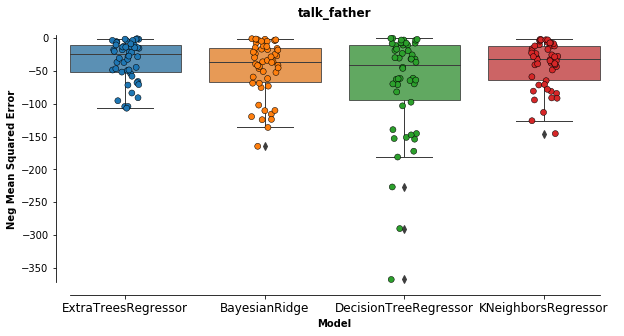

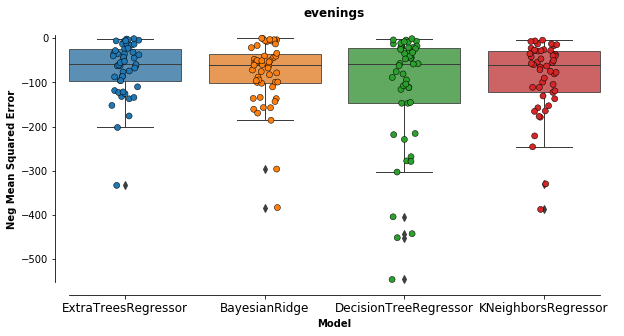

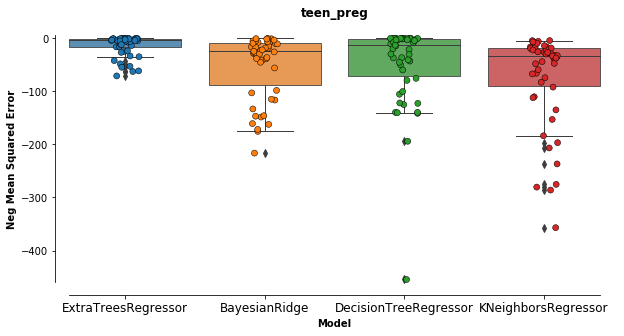

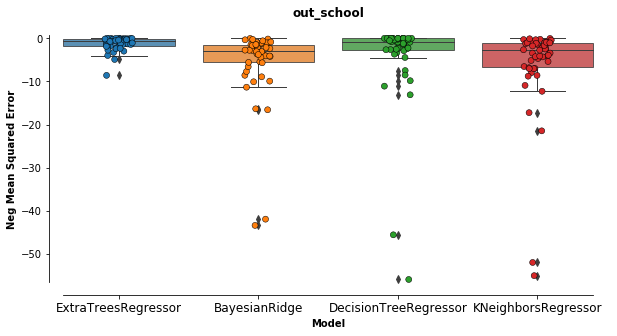

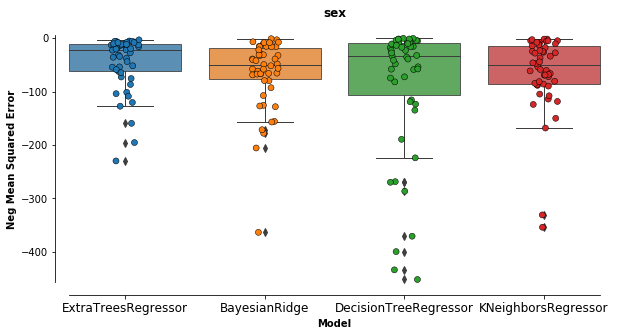

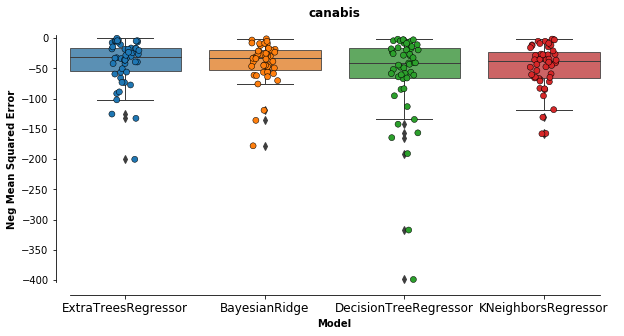

In [8]:
variables = cv_df['variable'].unique()

for variable in variables:

    plt.figure(figsize = (10,5))
    ax = sns.boxplot(x='model_name', y='error', data=cv_df.loc[cv_df['variable'] == variable],boxprops=dict(alpha=.8),linewidth=1)
    sns.stripplot(x='model_name', y='error', data=cv_df.loc[cv_df['variable'] == variable], 
                  size=6, jitter=True, edgecolor="black", linewidth=.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=360, fontsize =12) 
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    plt.title(variable,  fontweight = "bold")
    plt.xlabel('Model',  fontweight = "bold")
    plt.ylabel('Neg Mean Squared Error',  fontweight = "bold")
    plt.show()

# 1.2. Outliers
---

In [9]:
df = pd.concat([df[target], impute_df], axis = 1)

In [10]:
df_test = pd.concat([df_test[target], impute_test], axis = 1)

Target Distribution


<function matplotlib.pyplot.show(*args, **kw)>

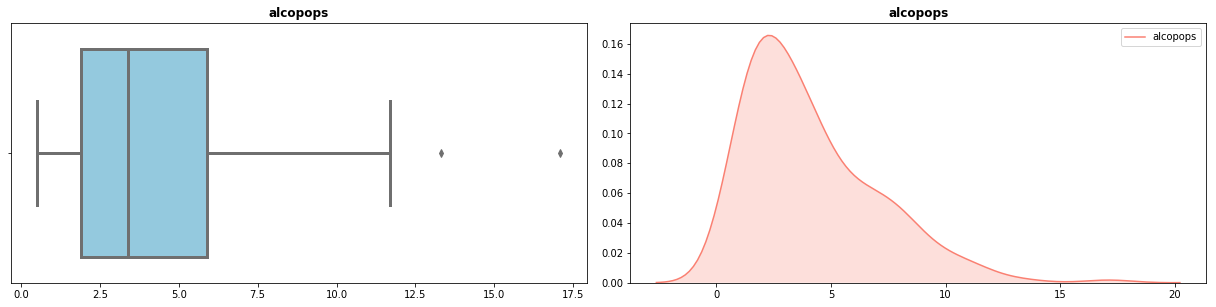

In [11]:
# Target distribution
print('Target Distribution')
fig = plt.figure(figsize=(17, 80))
col = target
ax = fig.add_subplot(df.shape[1], 2, 1)
box = sns.boxplot(x=col,data=df, linewidth=3, color="skyblue")
ax.set_title(col, fontweight = 'bold')
ax.set_xlabel(None)
ax = fig.add_subplot(df.shape[1], 2, 2)
p1 = sns.kdeplot(df[col],shade=True,color = 'salmon')
ax.set_title(col, fontweight = 'bold')
plt.tight_layout()
plt.show

In [12]:
columns_to_check = df.drop(columns = ['gender', 'year_collect',target]).columns
df_outlier_check = df[columns_to_check]

<function matplotlib.pyplot.show(*args, **kw)>

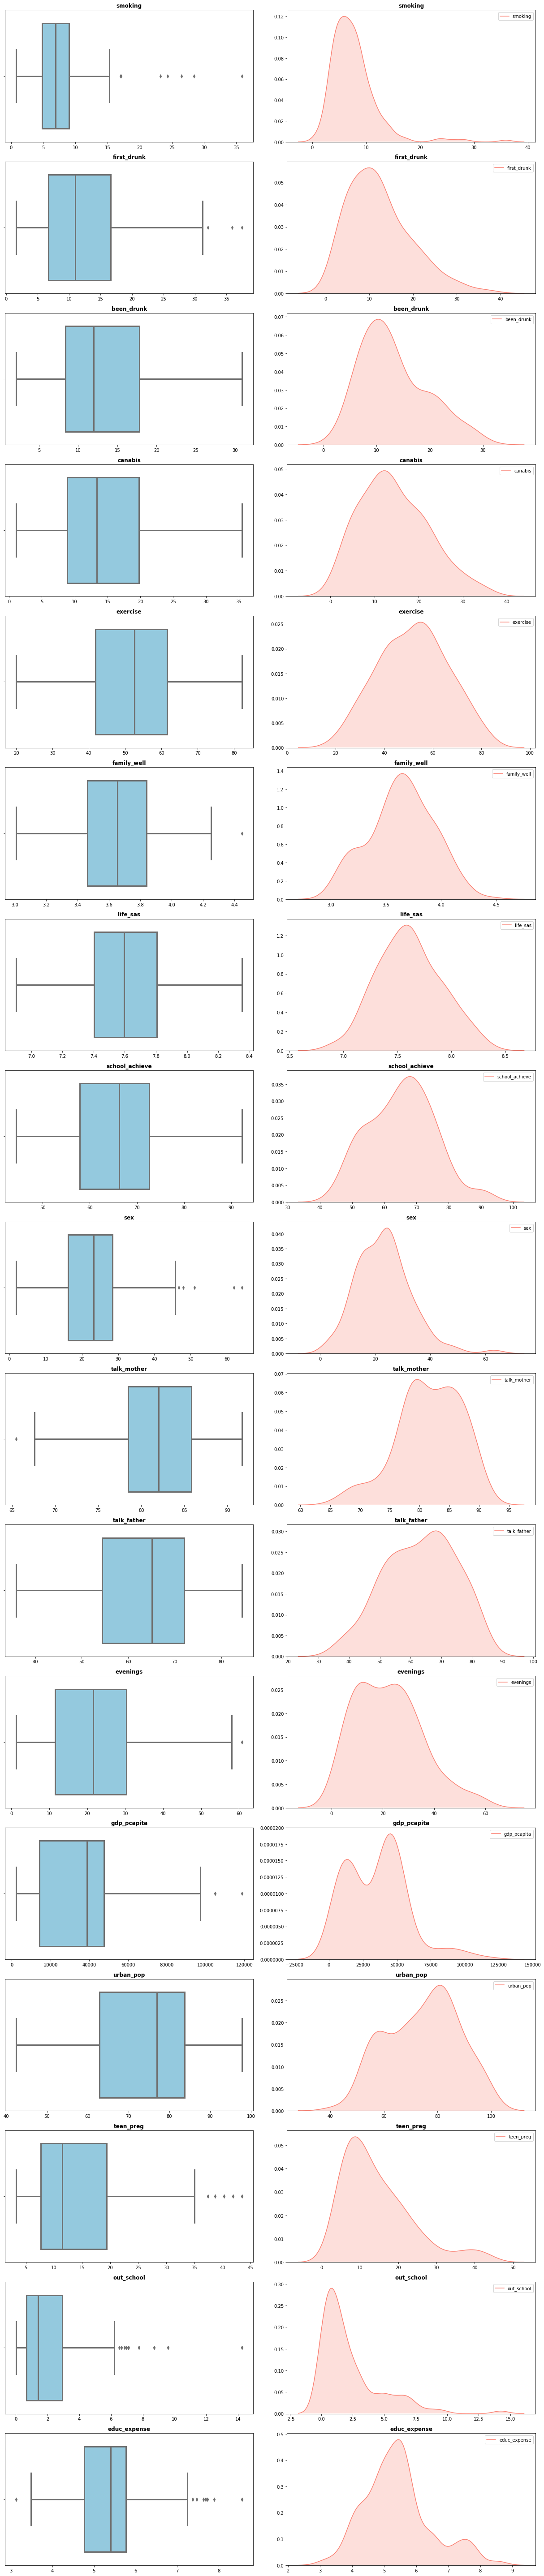

In [13]:
fig = plt.figure(figsize=(17, 80))
i = 1
for col in columns_to_check:
    ax = fig.add_subplot(df_outlier_check.shape[1], 2, i)
    box = sns.boxplot(x=col,data=df_outlier_check, linewidth=3, color="skyblue")
    ax.set_title(col, fontweight = 'bold')
    ax.set_xlabel(None)
    ax = fig.add_subplot(df_outlier_check.shape[1], 2, i+1)
    p1 = sns.kdeplot(df_outlier_check[col],shade=True,color = 'salmon')#, shade=True, color="salmon", label='Neg Response')
    #p1 = sns.kdeplot(df.loc[df.Response==1,col], shade=True, color="skyblue", label='Pos Response')
    ax.set_title(col, fontweight = 'bold')
    #ax.legend(fontsize=15)
    i+=2
    
plt.tight_layout()
plt.show

## 1.1. Deal with outliers

In [14]:
def filter_by_std(series_, n_stdev=3.0, return_thresholds=False):
    mean_, stdev_ = series_.mean(), series_.std()
    cutoff = stdev_ * n_stdev
    lower_bound, upper_bound = mean_ - cutoff, mean_ + cutoff
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]

def filter_by_iqr(series_, k=1.5, return_thresholds=False):
    q25, q75 = np.percentile(series_, 25), np.percentile(series_, 75)
    iqr = q75-q25
    
    cutoff = iqr*k
    lower_bound, upper_bound = q25-cutoff, q75+cutoff
    
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]
    
def plot_filter_by_stdev(df, feature, n_stdev=3.0, color="red"):
    lower_bound, upper_bound = filter_by_std(df[feature], n_stdev=n_stdev, return_thresholds=True)
    if df[feature].min()<=0:
        plt.axvspan(min(df[feature][df[feature] <lower_bound], default=df[feature].min()), lower_bound, alpha=0.2, color=color)
    plt.axvspan(upper_bound, max(df[feature][df[feature] > upper_bound], default=df[feature].max()), alpha=0.2, color=color)
    plt.title("Outliers in {} by {} standard deviations:\n".format(feature, n_stdev), fontsize=11,fontweight = 'bold')
    
def plot_filter_by_iqr(df, feature, k=1.5, color="red"):
    lower_bound, upper_bound = filter_by_iqr(df[feature], k=k, return_thresholds=True)
    if df[feature].min()<=0:
        plt.axvspan(min(df[feature][df[feature] <lower_bound], default=df[feature].min()), lower_bound, alpha=0.2, color=color)
    plt.axvspan(upper_bound, max(df[feature][df[feature] > upper_bound], default=df[feature].max()), alpha=0.2, color=color)
    plt.title("Outliers in {} by {} k in IQR:\n".format(feature, k), fontsize=11,fontweight = 'bold')
    

In [15]:
# Don't Apply to year, gender and alcopops
exclude = ['gender','year_collect', target]
column_names = df.columns
columns_to_search = [column for column in column_names if column not in exclude]

In [16]:
outliers_dict=dict()
def add_outliers_method(method, idx_to_remove, outliers_dict):
    
    outliers_dict[method]= idx_to_remove 
    return(outliers_dict)

### para cada modelo:
* 1. winsoring 0.05 e 0.95
* 2. remover std
* 3. remover IQR
* 4. remover mahalanobis
* 5. remover isolation forest
* 6. transformar em log

In [17]:
# 1 winsoring
def winsoring_smooth(df, columns_to_search,p1, p2):
    smooth_df = df.copy()
    for feature in columns_to_search:
        q1 = np.percentile(smooth_df[feature], p1)
        q2 = np.percentile(smooth_df[feature], p2)
        
        # smooth
        smooth_df.loc[smooth_df[feature] > q2, feature] = q2
        smooth_df.loc[smooth_df[feature] < q1, feature] = q1
    return smooth_df

In [18]:
# 2 remover std

def remove_by_std(df,columns_to_search, std = 3):
    remove_idx = []
    for feature in columns_to_search:
        id_std = df[feature][filter_by_std(df[feature], std)].index.tolist()
        remove_idx.append(id_std)
        
    remove_idx = list(set([item for sublist in remove_idx for item in sublist]))
    return remove_idx

In [19]:
# 3 remover iqr

def remove_by_iqr(df,columns_to_search, k = 1.7):
    remove_idx = []
    for feature in columns_to_search:
        id_iqr = df[feature][filter_by_iqr(df[feature], k)].index.tolist()
        remove_idx.append(id_iqr)
        
    remove_idx = list(set([item for sublist in remove_idx for item in sublist]))
    return remove_idx

In [20]:
# 4 Mahalanobis

from scipy.spatial.distance import mahalanobis
import scipy as sp

def mahalanobis_dis(x):
    inv_cov = x.cov().values
    inv_cov = sp.linalg.inv(inv_cov)
    mean = x.mean().values
    md = pd.DataFrame(columns=['mahalanobis'], index=x.index)
    for i in x.index.values:
        md['mahalanobis'][i]=mahalanobis(x.loc[i,],mean,inv_cov)
    return(md)



def removal_mahal(df, columns_to_search, n_dev = 3):
    
    x = df[columns_to_search]
    
    # calculate mahalanobis distance
    mahal_dis=mahalanobis_dis(x)
    
    m_std=mahal_dis[mahal_dis.columns[0]].std()
    m_mean=mahal_dis[mahal_dis.columns[0]].mean()

    outliers=mahal_dis[mahal_dis[mahal_dis.columns[0]]>=(m_mean+(m_std*n_dev))]
    name = 'mahalanobis_'+str(n_dev)
    idx_mahalanobis = list(outliers.index)
 
    return idx_mahalanobis
    

In [21]:
# 5 Isolation Forest

from sklearn.ensemble import IsolationForest

def removal_isolation_forest(df, columns_to_search, seed):
    x = df[columns_to_search] 
    # training the model
    clf = IsolationForest(max_samples=500, random_state=seed)
    clf.fit(x)
    
    # predictions
    predictions = clf.predict(x)
    x['isolation_forest']=predictions.tolist()
    idx_isolation=x.loc[x['isolation_forest'] == -1].index.tolist()
    x.drop(columns=['isolation_forest'])
    return idx_isolation

In [22]:
# 6 LOG Transformation

def log_transform(df, columns_to_search):
    transformed_df = df.copy()
    
    for column in columns_to_search:

        transformed_df[column] = [np.log(x) if x != 0 else 0.0001 for x in df[column]]
    
    return transformed_df

In [23]:
outliers_dict = {'winsoring_smooth_5_95': winsoring_smooth(df, columns_to_search, p1 = 5, p2 = 95),
                 'winsoring_smooth_10_90': winsoring_smooth(df, columns_to_search, p1 = 10, p2 = 90),
                 'remove_by_std_3': remove_by_std(df,columns_to_search, std = 3),
                 'remove_by_std_4': remove_by_std(df,columns_to_search, std = 4),
                 'remove_by_iqr_1.7': remove_by_iqr(df,columns_to_search, k = 1.7),
                 'remove_by_iqr_2': remove_by_iqr(df,columns_to_search, k = 2),
                 'removal_mahal_3': removal_mahal(df, columns_to_search, n_dev = 3),
                 'removal_mahal_4': removal_mahal(df, columns_to_search, n_dev = 4),
                 'removal_isolation_forest': removal_isolation_forest(df, columns_to_search, seed),
                 'log': log_transform(df, columns_to_search)}

In [24]:
from sklearn.model_selection import cross_val_score, KFold

CV = 100

entries = []

compare_outlier_methods =pd.DataFrame()


In [25]:
entries = []
for method, idx_list in outliers_dict.items():
    
    if method == 'winsoring_smooth':
        df_tmp = idx_list.copy()
    elif method == 'log':
        df_tmp = idx_list.copy()
    else:
        df_tmp = df.loc[set(df.index)-set(idx_list)]
        
    x_ = df_tmp.drop(columns = target)
    y_ = df_tmp[target]
    
    # scale data
    scaler = MinMaxScaler()
    x_ = scaler.fit_transform(x_)
    
    accuracies = cross_val_score(LinearRegression(), x_, y_, scoring='neg_mean_squared_error', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((method, fold_idx, accuracy))
        
outliers_df = pd.DataFrame(entries, columns=['method', 'fold_idx', 'error'])
compare_outlier_methods['error'] = outliers_df.groupby('method')['error'].agg('mean')
compare_outlier_methods.sort_values(by = 'error', ascending = False, inplace=True)

# !!!  Ver diferenca absoluta entre erro validation e erro training
# !!! Adicionar modelos ao benchmark

In [26]:
compare_outlier_methods

,error
method,
remove_by_iqr_1.7,-5.277697
remove_by_std_4,-5.848548
remove_by_std_3,-5.884950
remove_by_iqr_2,-6.207181
log,-6.232874
winsoring_smooth_10_90,-6.327474
winsoring_smooth_5_95,-6.327474
removal_mahal_3,-6.709978
removal_mahal_4,-6.762506


In [27]:
best_method = compare_outlier_methods.index[0]
print('>>> Best outlier method:', best_method)

>>> Best outlier method: remove_by_iqr_1.7


In [28]:
# smooth outliers to remove
outliers_dict['remove_by_std_4']

[109, 48, 49, 31, 190, 191]

In [29]:
# select df according to best method


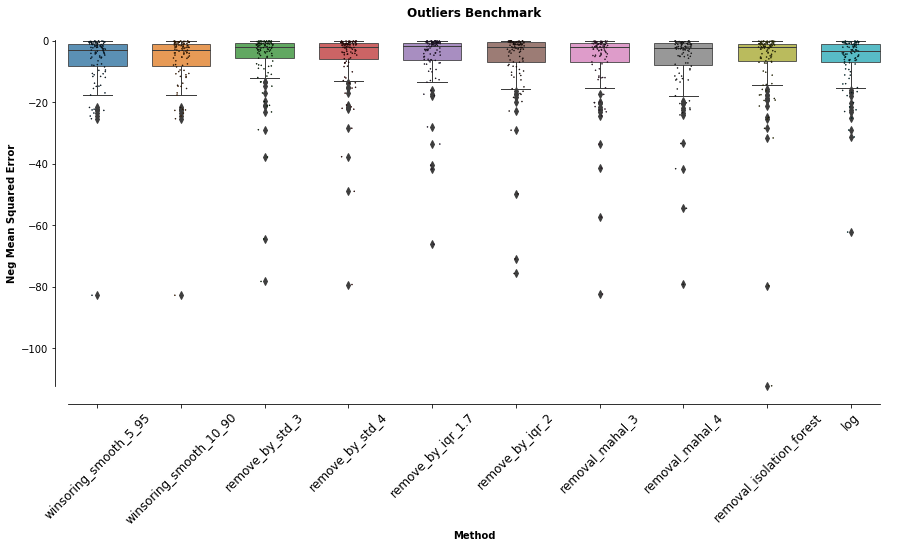

In [30]:
plt.figure(figsize = (15,7))
ax = sns.boxplot(x='method', y='error', data=outliers_df,boxprops=dict(alpha=.8),linewidth=1, width = 0.7)
sns.stripplot(x='method', y='error', data=outliers_df, 
              size=1, jitter=True, edgecolor="black", linewidth=.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize =12) 
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
plt.title('Outliers Benchmark',  fontweight = "bold")
plt.xlabel('Method',  fontweight = "bold")
plt.ylabel('Neg Mean Squared Error',  fontweight = "bold")
plt.show()

# 3. Feature Selection
---

In [31]:
df = pd.concat([df[target], impute_df], axis = 1)

In [32]:
df_test = pd.concat([df_test[target], impute_test], axis = 1)

## 3.1 Variable Worth

In [33]:
# Split data into features and Labels
x = df.drop(columns = target)
y = df[target]

# Normalize Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_ = scaler.fit_transform(x)
x = pd.DataFrame(x_, columns = x.columns, index=x.index)

In [34]:
def plot_importance(df,measure, top = 20):
    to_plot = pd.DataFrame(df[measure]).head(top).sort_values(by=measure)

    # 1 font
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    # 2 axis style

    plt.rcParams['axes.edgecolor']='black'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='black'
    plt.rcParams['ytick.color']='black'

    # plot
    my_range=range(1,len(to_plot.index)+1)
    fig, ax = plt.subplots(figsize=(5,5))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.hlines(y=my_range, xmin=0, xmax = to_plot[measure], color='black', alpha=0.4)
    plt.plot(to_plot[measure], my_range, "o", markersize=6, color='black', alpha=0.6)
    plt.yticks(my_range, to_plot.index,fontsize=10, fontweight = 'bold')
    # set labels style
    ax.set_title(measure, fontweight = 'bold')
    ax.set_xlabel('Importance', fontsize=10, fontweight='black', color = 'black')
    ax.set_ylabel('')
    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

### 3.1.1. Chi2

In [35]:
def chisq_ranker(df, continuous_flist, target, categorical_flist = None ,n_bins=10, binning_strategy="uniform",):
    chisq_dict = {}
    if  continuous_flist:
        bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', 
                               strategy=binning_strategy)
        for feature in continuous_flist:            
            feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
            feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
            cont_tab = pd.crosstab(feature_bin, df[target], margins = False)
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2] 
    if  categorical_flist:
        for feature in categorical_flist:  
            cont_tab = pd.crosstab(df[feature], df[target], margins = False)          
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2]       
    
    return chisq_dict

In [36]:
continuous_flist = list(df.select_dtypes(include=["number"]).drop(columns = target).columns)

chisq_rank=chisq_ranker(df, continuous_flist, target)
chisq_rank
df_chisq_rank = pd.DataFrame(chisq_rank, index=["Chi-Squared", "p-value"]).transpose()
df_chisq_rank.sort_values("Chi-Squared", ascending=False, inplace=True)
df_chisq_rank["valid"]=df_chisq_rank["p-value"]<=0.05
# chi 
chi_sq = pd.DataFrame(df_chisq_rank['Chi-Squared']).rank(ascending=False).astype('int64')
chi_sq.head()

,Chi-Squared
first_drunk,1
been_drunk,2
school_achieve,3
exercise,4
teen_preg,5


### 3.1.2. Linear Regression

In [37]:
r_squared = []
coef = []
p_val = []

for var in x.columns: 
    x_ = x[var]
    mod = sm.OLS(y, sm.add_constant(x_)).fit()
    r_squared.append(np.round(mod.rsquared, decimals = 3))
    coef.append(np.round(mod.params[1], decimals = 3))
    p_val.append(mod.pvalues[1])

In [38]:
# DataFrame
LinReg = pd.DataFrame({"variable":x.columns, "R2": r_squared, "coef": coef, 'pvalue':p_val})
LinReg['valid']  = LinReg['pvalue'] <=0.05
LinReg.sort_values(by="R2", ascending = False,inplace=True)
LinReg.set_index("variable", inplace=True)

LinReg_ = pd.DataFrame(LinReg.R2)
LinReg = pd.DataFrame(LinReg.R2).rank(ascending=False).astype('int64')
LinReg.rename(index=str, columns={"R2": "LinReg"},inplace=True)
LinReg.head()

,LinReg
variable,
first_drunk,1
been_drunk,2
year_collect,3
smoking,4
sex,5


### 3.1.3. Random Forest

In [39]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(random_state=seed)
clf.fit(x,y)

preds = clf.predict(x)

rf_ = pd.DataFrame(clf.feature_importances_, columns = ["RF"], index=x.columns)
rf = pd.DataFrame(clf.feature_importances_, columns = ["RF"], index=x.columns).rank(ascending=False).astype('int64')
rf.sort_values(by='RF').head()

,RF
smoking,1
first_drunk,2
sex,3
gdp_pcapita,4
life_sas,5


### 3.1.4. RFE 

In [40]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
model = LinearRegression()
rfe = RFE(model, 1)
fit = rfe.fit(x, y)
rfe = pd.DataFrame(rfe.ranking_, columns = ["RFE"], index=x.columns)
rfe_ = rfe.copy().sort_values(by='RFE',ascending=False)
rfe.sort_values(by='RFE').head()

,RFE
first_drunk,1
talk_father,2
talk_mother,3
gender,4
sex,5


### 3.1.5. Extra trees classifier

In [41]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(random_state = seed)
model.fit(x, y)
extc_ = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=x.columns)
extc = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=x.columns).rank(ascending=False).astype('int64')
extc.sort_values(by='Extratrees').head()

,Extratrees
smoking,1
year_collect,2
been_drunk,3
first_drunk,4
teen_preg,5


### 3.1.6. Decision Trees

In [42]:
# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=seed)
dtree = dtree.fit(x, y)
dtree_ = pd.DataFrame(dtree.feature_importances_, columns = ["Dt"], index=x.columns)
dtree = pd.DataFrame(dtree.feature_importances_, columns = ["Dt"], index=x.columns).rank(ascending=False).astype('int64')
dtree.sort_values(by='Dt').head()

,Dt
first_drunk,1
life_sas,2
gdp_pcapita,3
urban_pop,4
smoking,5


### 3.1.6. WOE

In [43]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [44]:
final_iv, IV = data_vars(df[df.columns.difference([target])],df[target])
IV.set_index('VAR_NAME',inplace=True)
IV_rank = IV.rank(ascending=False).astype('int64')

In [45]:
transform_vars_list = df.columns.difference([target])
transform_prefix = 'WOE_' 

df_woe = df.copy()

for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df_woe[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            df_woe[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))

In [46]:
woe_columns = [x for x in df_woe.columns if x.startswith('WOE_')]

df_woe = df_woe[woe_columns]
df_woe = pd.concat([df_woe, df[target]],axis=1)
df_woe.head(2)

,WOE_been_drunk,WOE_canabis,WOE_educ_expense,WOE_evenings,WOE_exercise,WOE_family_well,WOE_first_drunk,WOE_gdp_pcapita,WOE_gender,WOE_life_sas,WOE_out_school,WOE_school_achieve,WOE_sex,WOE_smoking,WOE_talk_father,WOE_talk_mother,WOE_teen_preg,WOE_urban_pop,WOE_year_collect,alcopops
0,0.054858,0.020550,-0.028097,0.016219,-0.015255,-0.02151,0.009313,-0.02965,-0.031269,0.030297,0.024624,0.030976,-0.067730,0.142401,0.001951,0.026436,-0.062601,-0.015321,0.184271,2.3
1,0.240558,0.127018,0.036485,-0.014117,-0.015255,-0.02151,0.142380,-0.02965,0.038325,0.030297,0.024624,0.030976,0.110591,0.361753,-0.001869,0.026436,-0.062601,-0.015321,0.184271,0.9


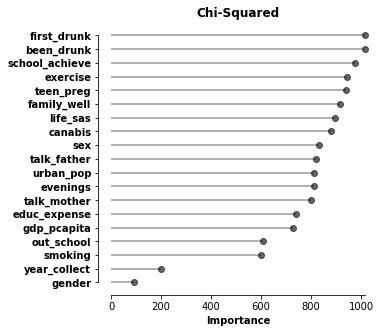

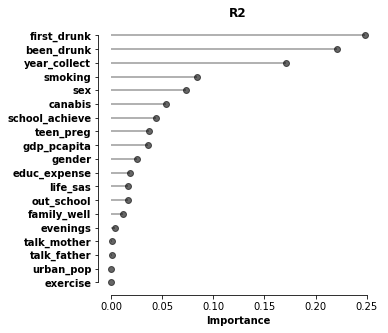

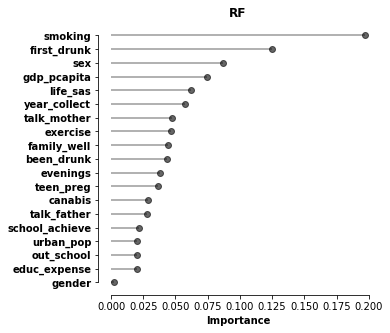

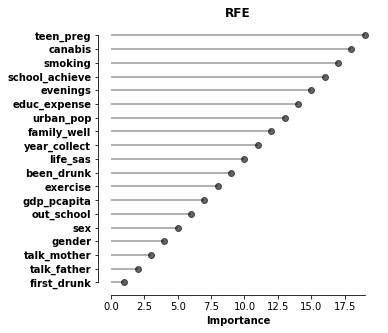

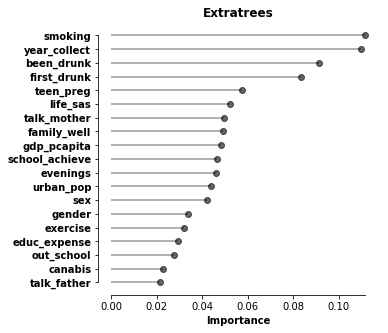

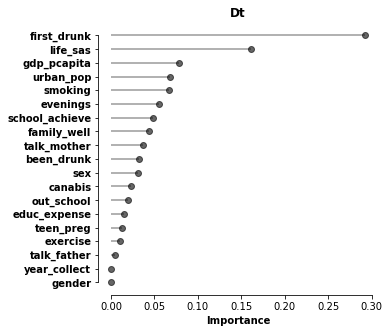

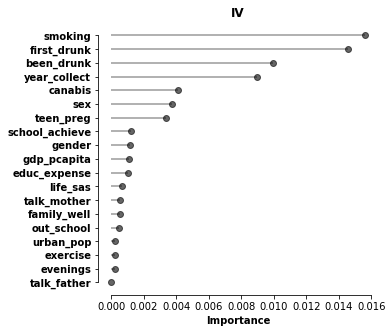

In [47]:
methds = [df_chisq_rank,LinReg_,rf_,rfe_,extc_,dtree_,IV]
for met in methds:
    plot_importance(met,met.columns[0])

In [48]:
from functools import reduce
dfs = [chi_sq, LinReg, rf, rfe, extc, dtree, IV_rank]
compare_models = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)

# Vote
compare_models['Ranking'] = compare_models.sum(axis=1).rank(ascending=True).astype('int64')
compare_models.sort_values(by='Ranking',inplace=True)
compare_models['Valid'] = df_chisq_rank.valid
compare_models.head()

,Chi-Squared,LinReg,RF,RFE,Extratrees,Dt,IV,Ranking,Valid
first_drunk,1,1,2,1,4,1,2,1,True
been_drunk,2,2,10,9,3,10,3,2,True
smoking,17,4,1,17,1,5,1,3,False
sex,9,5,3,5,13,11,6,4,True
life_sas,7,12,5,10,6,2,12,5,False


In [49]:
## VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

features_ = df[list(compare_models[compare_models['Ranking'] <=15].index)]

vif = calculate_vif(features_)
vif

while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features_.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features_)

vif

vif_selected_variables = list(vif['Features']) #+ ['Response']

vif_selected_variables

['first_drunk',
 'smoking',
 'sex',
 'gdp_pcapita',
 'teen_preg',
 'canabis',
 'evenings']

## 3.2. Remove correlated features by importance order

In [50]:
not_valid = compare_models.loc[compare_models.Valid==0].index.values
not_valid

array(['smoking', 'life_sas', 'gdp_pcapita', 'year_collect',
       'talk_mother', 'canabis', 'evenings', 'urban_pop', 'gender',
       'out_school', 'talk_father', 'educ_expense'], dtype=object)

In [51]:
#### 1 Using correlation

# lista com variaveis ordenadas por importancia
# para cada ver a correlacao com as outras
# se for acima de 70% retirar essa var da lista

# Lista com features ordenadas por importância para explicar a variável target
col_ordered = compare_models.index

# Dataset com apenas as variáveis númericas
x_ = x[col_ordered]
columns = np.full(x_.columns.shape[0], True, dtype=bool)

corr = x_.corr()
to_keep = -1

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = x_.columns[columns][:to_keep]
# remove non valid variables
selected_columns = [x for x in selected_columns if x not in not_valid]
selected_columns
#df_after_remove = pd.concat([x[selected_columns].iloc[:,:to_keep],y],axis=1)    
#print(df_after_remove.columns)
#df_after_remove.head(1)

['first_drunk',
 'sex',
 'school_achieve',
 'teen_preg',
 'family_well',
 'exercise']

# 4. Decomposition 
---

## 4.1. PCA

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [53]:
n_components = x.shape[1]
i = 1
achieved = False
for n in range(n_components):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x)
    cumulative_var = np.sum(pca.explained_variance_ratio_ * 100)
    if cumulative_var >= 80 and achieved == False:
        threshold_80_percent = i
        achieved = True
        print('\n>>> PCA 80% of cumulative explained Variance achieved with: {} components\n'.format(i))
    i += 1
pca_board = pd.DataFrame({"Explained_Var": np.round(pca.explained_variance_ratio_ * 100, decimals=1),
                          "Cumulative_Var": np.round(np.cumsum(pca.explained_variance_ratio_ * 100),
                                                     decimals=2)})
pca_board.index.name = 'PC'
pca_board.index += 1
print(pca_board)


>>> PCA 80% of cumulative explained Variance achieved with: 6 components

    Explained_Var  Cumulative_Var
PC                               
1            28.8           28.80
2            18.8           47.60
3            13.9           61.51
4             9.1           70.64
5             6.1           76.73
6             3.9           80.58
7             3.6           84.15
8             3.1           87.27
9             2.2           89.50
10            1.9           91.42
11            1.8           93.27
12            1.7           94.93
13            1.3           96.28
14            1.2           97.49
15            1.0           98.50
16            0.8           99.27
17            0.3           99.58
18            0.2           99.81
19            0.2          100.00


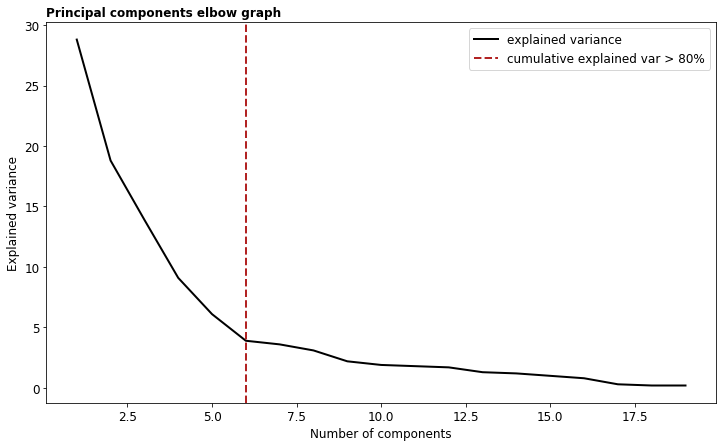

In [54]:
# plot elobe graph

plt.figure(figsize=(12, 7))
plt.plot(pca_board.Explained_Var, color="black", label="explained variance", linewidth=2)
plt.xlabel('Number of components', fontsize = 12)
plt.ylabel('Explained variance', fontsize = 12)
plt.title("Principal components elbow graph", loc="left", fontweight="bold", fontsize = 12)
plt.axvline(x=threshold_80_percent, alpha=2, color="firebrick", linestyle="--",linewidth=2,
            label="cumulative explained var > 80%")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
#plt.show()

    # See how each variable is epxlinaed by each component
pca_index = []

for i in range(1, n_components + 1):
    pca_index.append('PC' + str(i))

In [55]:
print(pd.DataFrame(np.round(pca.components_ * 100, 2),columns=x.columns,index=pca_index))

agg_pca = pd.DataFrame(principalComponents,columns=pca_index)
pca_df = pd.DataFrame(principalComponents, columns=pca_index, index=x.index).iloc[:, : threshold_80_percent]
pca_df = pd.concat([pca_df, df[target]],axis=1)
#pca_df.to_excel("df_PCA.xlsx")

      gender  smoking  first_drunk  been_drunk  canabis  exercise  \
PC1   -85.91    -2.04       -11.31      -12.29   -11.08    -20.67   
PC2     1.20   -10.15       -27.77      -28.73   -13.41      3.06   
PC3    -5.11     5.94        10.13       10.60   -17.74    -38.14   
PC4    -8.97   -12.33       -19.56      -22.59   -40.06     11.85   
PC5   -25.73    13.74        33.18       38.11     6.58      9.02   
PC6    18.63    -7.15       -10.49      -18.86   -34.53    -13.22   
PC7     3.95     5.47        11.42       12.11   -33.53    -17.11   
PC8    -9.53    -0.74         0.82       12.49   -19.55      4.77   
PC9     1.56   -18.39        20.94       23.72   -11.95     12.29   
PC10   -8.48    45.54         8.34       -4.27   -33.47     13.49   
PC11    1.06    22.99        -9.79      -23.01    38.81    -47.50   
PC12   -9.96    -4.75       -31.53      -10.24    25.16     26.17   
PC13   16.52    -6.24       -21.31       -7.12   -22.63    -16.03   
PC14   -5.01   -19.07        -1.68

In [56]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,alcopops
0,-0.583973,0.564551,0.743522,0.019991,-0.027373,-0.080056,2.3
1,0.632424,0.700055,0.744277,0.399942,-0.280927,-0.185234,0.9
2,-0.653598,0.611485,0.029396,0.089670,-0.154031,-0.181141,4.4
3,0.470800,0.570204,0.043618,0.046915,-0.082674,-0.199172,3.6
6,-0.397828,0.556061,-0.644815,-0.218691,-0.053185,0.152688,1.8


## 4.2. Factor Analysis

In [57]:
from sklearn.decomposition import FactorAnalysis as FA

In [58]:
n_components = threshold_80_percent
fa = FA(n_components = n_components, random_state=seed)
fa_df = fa.fit_transform(x)
sum(fa.noise_variance_)  

0.3644892131072744

In [59]:
fa_index = []
for i in range(1, n_components + 1):
    fa_index.append('Fact' + str(i))
fa_df = pd.DataFrame(fa_df, columns = fa_index,index=x.index)
fa_df = pd.concat([fa_df, df[target]],axis=1)
fa_df.head()

,Fact1,Fact2,Fact3,Fact4,Fact5,Fact6,alcopops
0,-1.283614,-1.098863,0.771645,-1.323335,-0.138223,0.710677,2.3
1,0.762521,-1.916323,0.841541,-0.999836,-1.810727,1.026885,0.9
2,-1.037559,-0.754887,-0.616052,0.181160,0.477128,-0.002366,4.4
3,0.860175,-0.881946,-0.149083,0.370315,0.483203,-0.173617,3.6
6,-0.652554,-0.128505,-1.445646,0.274071,0.034520,-1.752430,1.8


## 4.3. ICA

In [60]:
from sklearn.decomposition import FastICA

In [61]:
n_components = threshold_80_percent
ica = FastICA(n_components=n_components, random_state=seed)
ica_df = ica.fit_transform(x)

In [62]:
ica_index = []
for i in range(1, n_components + 1):
    ica_index.append('ICA' + str(i))
ica_df = pd.DataFrame(ica_df, columns = ica_index,index=x.index)
ica_df = pd.concat([ica_df, df[target]],axis=1)
ica_df.head()

,ICA1,ICA2,ICA3,ICA4,ICA5,ICA6,alcopops
0,-0.066072,-0.009060,0.053419,0.091537,-0.088814,-0.078433,2.3
1,0.077293,-0.099463,0.122743,0.105005,-0.071346,-0.057294,0.9
2,-0.078835,-0.035707,0.081521,0.003731,-0.077192,0.014070,4.4
3,0.058058,-0.025340,0.070288,0.008797,-0.077637,0.021897,3.6
6,-0.059036,-0.038655,-0.064251,-0.075313,-0.076055,0.079327,1.8


## 4.4. TSNE

In [63]:
from sklearn.manifold import TSNE 


In [64]:
n_components = 3
tsne = TSNE(n_components=n_components, n_iter=250,random_state=seed)
tsne_df = tsne.fit_transform(x.values)

In [65]:
tsne_names = []
for i in range(1, n_components + 1):
    tsne_names.append('TSNE' + str(i))

tsne_df = pd.DataFrame(tsne_df, index = x.index, columns=tsne_names)
tsne_df = pd.concat([tsne_df, df[target]],axis=1)
tsne_df.head()

,TSNE1,TSNE2,TSNE3,alcopops
0,-22.775312,-46.219002,-41.954590,2.3
1,-2.175122,0.669142,-1.345582,0.9
2,1.347344,0.082115,1.236462,4.4
3,-2.340999,0.614777,-1.769816,3.6
6,1.590361,-0.249574,1.234390,1.8


# 4.5. Kernel PCA

In [66]:
from sklearn.decomposition import KernelPCA as KPCA

In [67]:
n_components = threshold_80_percent
kpca = KPCA(n_components = n_components, random_state=seed, kernel='linear')
kpca_df = kpca.fit_transform(x)

In [68]:
kpca_names = []
for i in range(1, n_components + 1):
    kpca_names.append('KPCA' + str(i))

kpca_df = pd.DataFrame(kpca_df, index = x.index, columns=kpca_names)
kpca_df = pd.concat([kpca_df, df[target]],axis=1)
kpca_df.head()

,KPCA1,KPCA2,KPCA3,KPCA4,KPCA5,KPCA6,alcopops
0,-0.583973,-0.564551,-0.743522,0.019991,0.027373,0.080056,2.3
1,0.632424,-0.700055,-0.744277,0.399942,0.280927,0.185234,0.9
2,-0.653598,-0.611485,-0.029396,0.089670,0.154031,0.181141,4.4
3,0.470800,-0.570204,-0.043618,0.046915,0.082674,0.199172,3.6
6,-0.397828,-0.556061,0.644815,-0.218691,0.053185,-0.152688,1.8


## 4.6. Feature Agglomeration

In [69]:
from sklearn import cluster

In [70]:
n_clusters = threshold_80_percent
agglo = cluster.FeatureAgglomeration(n_clusters=n_clusters)
agglo.fit(x) 
x_reduced = agglo.transform(x)

In [71]:
clust_names = []
for i in range(1, n_clusters + 1):
    clust_names.append('CLUST' + str(i))

In [72]:
x_reduced = pd.DataFrame(x_reduced, index = x.index, columns=clust_names)
x_reduced = pd.concat([x_reduced, df[target]],axis=1)
x_reduced.head()

,CLUST1,CLUST2,CLUST3,CLUST4,CLUST5,CLUST6,alcopops
0,0.700472,0.225419,0.323290,1.0,0.362911,1.0,2.3
1,0.622856,0.221003,0.292901,1.0,0.044964,0.0,0.9
2,0.643970,0.491421,0.163027,1.0,0.286517,1.0,4.4
3,0.504418,0.438366,0.166826,1.0,0.197514,0.0,3.6
6,0.341308,0.725373,0.080021,1.0,0.236005,1.0,1.8


## 4.7. Gaussian Random Projection

In [73]:
from sklearn.random_projection import GaussianRandomProjection

n_components = threshold_80_percent
grp = GaussianRandomProjection(n_components =n_components,random_state=seed)
rand_proj = grp.fit_transform(x)

In [74]:
rand_names = []
for i in range(1, n_components + 1):
    rand_names.append('GRP' + str(i))

grp_df = pd.DataFrame(rand_proj, index = x.index, columns=rand_names)
grp_df = pd.concat([grp_df, df[target]],axis=1)
grp_df.head()

,GRP1,GRP2,GRP3,GRP4,GRP5,GRP6,alcopops
0,2.477633,0.805609,-1.625554,-0.733705,0.885238,1.894964,2.3
1,0.902362,0.655414,-1.402057,-0.165559,1.199319,1.967349,0.9
2,2.170171,0.294442,-1.088717,-0.867130,0.558583,2.148918,4.4
3,1.060321,0.343485,-0.777771,-0.677724,1.041003,1.855035,3.6
6,1.877798,0.357885,-0.987571,-0.113256,1.071490,3.496988,1.8


# 5. Best power transformation for selected features
---

In [75]:
# 2) & 3) perform power transformations on scaled features and select the best
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import boxcox


# define a set of transformations
trans_dict = {'x': lambda x: x,
              #'1/x': lambda x: np.divide(1, x),
              'log': np.log,
              'sqrt': np.sqrt,
              'exp': np.exp,
              '**1/3': lambda x: np.power(x, 1/3),
              '**1/4': lambda x: np.power(x, 0.25),
              '**1/5': lambda x: np.power(x, 1/5),
              '**1/6': lambda x: np.power(x, 1/6),
              '**1/7': lambda x: np.power(x, 1/7),
              '**2': lambda x: np.power(x, 2),
              '**4': lambda x: np.power(x, 4)}

In [76]:
# 1 SCALING

scaler = MinMaxScaler()
X_01 = scaler.fit_transform(df.drop(columns = target).values)

column_names01 = [s + "_01T" for s in df.drop(columns = target).columns]
df_01T = pd.concat([df, pd.DataFrame(X_01, index=df.index, columns=column_names01)], axis=1)

display(df_01T.head(3))

,alcopops,gender,smoking,first_drunk,been_drunk,canabis,exercise,family_well,life_sas,school_achieve,...,sex_01T,talk_mother_01T,talk_father_01T,evenings_01T,year_collect_01T,gdp_pcapita_01T,urban_pop_01T,teen_preg_01T,out_school_01T,educ_expense_01T
0,2.3,1,4.4,12.5,10.7,10.0,34.7,3.282,8.139,79.6,...,0.59069,0.904580,0.927984,0.593277,1.0,0.020020,0.251676,0.433259,0.434048,0.393645
1,0.9,0,1.2,5.5,3.9,1.4,20.3,3.303,8.278,87.6,...,0.00000,1.000000,0.524691,0.157983,1.0,0.020020,0.251676,0.433259,0.434048,0.607492
2,4.4,1,6.4,7.2,10.9,12.5,72.4,3.933,8.143,61.5,...,0.35313,0.740458,0.771605,0.497479,1.0,0.424371,0.271609,0.112963,0.216573,0.427261


In [77]:
# 2 / 3 Chi square

# best transformation dictionary for each feature
best_power_dict = {}

# take scaled columns

scaled_cols = [col for col in df_01T if col.endswith('01T')]

for feature in scaled_cols:
    max_test_value, max_trans, best_power_trans = 0, "", None
    for trans_key, trans_value in trans_dict.items():
        
        # apply transformation itself
        
        feature_trans = trans_value(df_01T[feature])
        if trans_key == "log":
            feature_trans.loc[np.isfinite(feature_trans) == False] = -50
            
        # bin feature
        
        bindisc = KBinsDiscretizer(n_bins = 10, encode = "ordinal", strategy = "uniform")
        feature_bin = bindisc.fit_transform(feature_trans.values[:, np.newaxis])
        feature_bin = pd.Series(feature_bin[:, 0], index = df_01T.index)
        
        # obtain contigency table
        
        df_ = pd.DataFrame(data = {feature: feature_bin, target: df_01T[target]})
        cont_tab = pd.crosstab(df_[feature], df_[target], margins = False)
        
        # compute Chi-Square test
        
        chi_test_value = stats.chi2_contingency(cont_tab)[0]
        if chi_test_value > max_test_value:
            max_test_value, max_trans, best_power_trans = chi_test_value, trans_key, feature_trans
            
    
    best_power_dict[feature] = (max_test_value, max_trans, best_power_trans)
    df_01T[feature] = best_power_trans

In [78]:
# BEST TRANSFORM
print("The best power transformations:")
for key in best_power_dict:
    print("\t>>>", key, best_power_dict[key][1]) 

df_01T.head(3, )

The best power transformations:
	>>> gender_01T x
	>>> smoking_01T sqrt
	>>> first_drunk_01T x
	>>> been_drunk_01T **4
	>>> canabis_01T sqrt
	>>> exercise_01T **1/3
	>>> family_well_01T **1/3
	>>> life_sas_01T sqrt
	>>> school_achieve_01T x
	>>> sex_01T sqrt
	>>> talk_mother_01T **4
	>>> talk_father_01T sqrt
	>>> evenings_01T **2
	>>> year_collect_01T x
	>>> gdp_pcapita_01T **1/4
	>>> urban_pop_01T **2
	>>> teen_preg_01T exp
	>>> out_school_01T **1/4
	>>> educ_expense_01T x


,alcopops,gender,smoking,first_drunk,been_drunk,canabis,exercise,family_well,life_sas,school_achieve,...,sex_01T,talk_mother_01T,talk_father_01T,evenings_01T,year_collect_01T,gdp_pcapita_01T,urban_pop_01T,teen_preg_01T,out_school_01T,educ_expense_01T
0,2.3,1,4.4,12.5,10.7,10.0,34.7,3.282,8.139,79.6,...,0.768564,0.669558,0.963319,0.351978,1.0,0.376154,0.063341,1.542276,0.811679,0.393645
1,0.9,0,1.2,5.5,3.9,1.4,20.3,3.303,8.278,87.6,...,0.000000,1.000000,0.724356,0.024959,1.0,0.376154,0.063341,1.542276,0.811679,0.607492
2,4.4,1,6.4,7.2,10.9,12.5,72.4,3.933,8.143,61.5,...,0.594247,0.300609,0.878410,0.247485,1.0,0.807117,0.073771,1.119590,0.682184,0.427261


In [79]:
# list of different feature selection methods
feat_select_dict = {'vif':[col + '_01T' for col in vif_selected_variables],
                    'correlation':[col + '_01T' for col in selected_columns]}

In [80]:
# see best variable selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
n_splits = 10
selectors_df = pd.DataFrame(index=range(len(feat_select_dict.keys())*n_splits), columns=(['method','mean_squared_error']))
CV = 20
score = 'neg_mean_squared_error'


In [81]:
entries = []
comparing_selectors =pd.DataFrame()
   
entries = []

model = LinearRegression()

for selector in feat_select_dict.keys():

    #x_train = scaler.fit_transform(df_01T[feat_select_dict[selector]])
    #y_train = df_01T[target]
    x_train = df_01T[feat_select_dict[selector]]
    y_train = df_01T[target]

    accuracies = cross_val_score(model,x_train, y_train, scoring= score, cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((selector, fold_idx, model.__class__.__name__, accuracy))

_ = pd.DataFrame(entries, columns=['method', 'fold_idx','model', score])
comparing_selectors[score] = _.groupby(['method'])[score].agg('mean')



In [82]:
comparing_selectors.sort_values(by = 'neg_mean_squared_error', ascending = False, inplace=True)
comparing_selectors

,neg_mean_squared_error
method,
vif,-6.711265
correlation,-6.758488


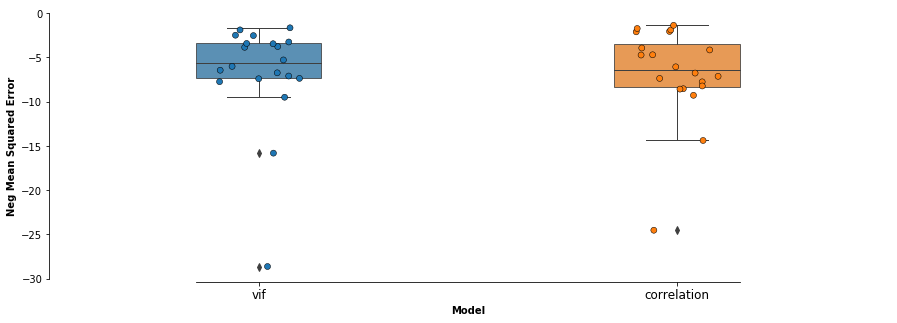

In [83]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x='method', y='neg_mean_squared_error', data=_,boxprops=dict(alpha=.8),linewidth=1, width = 0.3)

sns.stripplot(x='method', y='neg_mean_squared_error', data=_, 
              size=6, jitter=True, edgecolor="black", linewidth=.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, fontsize =12) 
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
#plt.title(variable,  fontweight = "bold")
plt.xlabel('Model',  fontweight = "bold")
plt.ylabel('Neg Mean Squared Error',  fontweight = "bold")
plt.show()

In [84]:
best_selector = comparing_selectors.index[0]
best_selector

'vif'

In [85]:
df_01T_best_selector = df_01T[feat_select_dict[best_selector]]
df_01T_best_selector = pd.concat([df_01T_best_selector,df_01T[target]], axis = 1)

### Transform Test Data

In [86]:
df_test.shape

(23, 20)

In [87]:
scaler = MinMaxScaler()
scaler.fit(df.drop(columns = target).values)
X_01 = scaler.transform(df_test.drop(columns = target).values)
df_test_01T = pd.concat([ pd.DataFrame(X_01, index=df_test.index, columns=column_names01), df_test[target]], axis=1)


In [88]:
# Apply transformations to test data
for key in best_power_dict:
    df_test_01T[key] = trans_dict[best_power_dict[key][1]](df_test_01T[key])

In [89]:
df_test_01T = df_test_01T[df_01T_best_selector.columns]

In [90]:
df_test_01T.head(1)

,first_drunk_01T,smoking_01T,sex_01T,gdp_pcapita_01T,teen_preg_01T,canabis_01T,evenings_01T,alcopops
64,0.256267,0.373632,0.58882,0.658782,1.032217,0.806947,0.117551,6.7


# Select best engineering for Models
---

* With best of variable selection
* Decomposition
* WOE

In [91]:
scaler = MinMaxScaler()
#var_selection = pd.DataFrame(scaler.fit_transform(df_test_01T.drop(columns = target).values), columns = df_test_01T.drop(columns = target).columns, index = df_test_01T.index)
#var_selection = pd.concat([var_selection, df_test_01T[target]], axis=1)
var_selection = df_01T_best_selector #df_test_01T.copy()
#df_test_01T

In [92]:
# let's choose engeneering that better predicts our target
df_collection = {'variable_selection': var_selection,#df_test_01T,
                 'woe': df_woe,
                 'pca': pca_df,
                 'fa': fa_df,
                 'ica':ica_df,
                 'tsne':tsne_df,
                 'kpca':kpca_df,
                 'feat_agglom':x_reduced,
                 'grp':grp_df}

In [93]:
n_splits = 1
selectors_df = pd.DataFrame(index=range(len(feat_select_dict.keys())*n_splits), columns=(['method','mean_squared_error']))
CV = 20
score = 'neg_mean_squared_error'

In [94]:
entries = []
comparing_eng = pd.DataFrame()
model = LinearRegression(n_jobs=-1)
entries = []

for df_ in df_collection.keys():

    x_train = df_collection[df_].drop(columns = target)
    y_train = df_collection[df_][target]

    accuracies = cross_val_score(model,x_train, y_train, scoring= score, cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((df_, fold_idx, df_, accuracy))

_ = pd.DataFrame(entries, columns=['method', 'fold_idx','model', score])
comparing_eng[score] = _.groupby(['method'])[score].agg('mean')


In [95]:
comparing_eng.sort_values(by = 'neg_mean_squared_error', ascending=False, inplace=True)
comparing_eng

,neg_mean_squared_error
method,
ica,-6.226678
kpca,-6.226678
pca,-6.226678
feat_agglom,-6.228484
fa,-6.459606
variable_selection,-6.711265
woe,-7.008248
grp,-7.170286
tsne,-8.544045


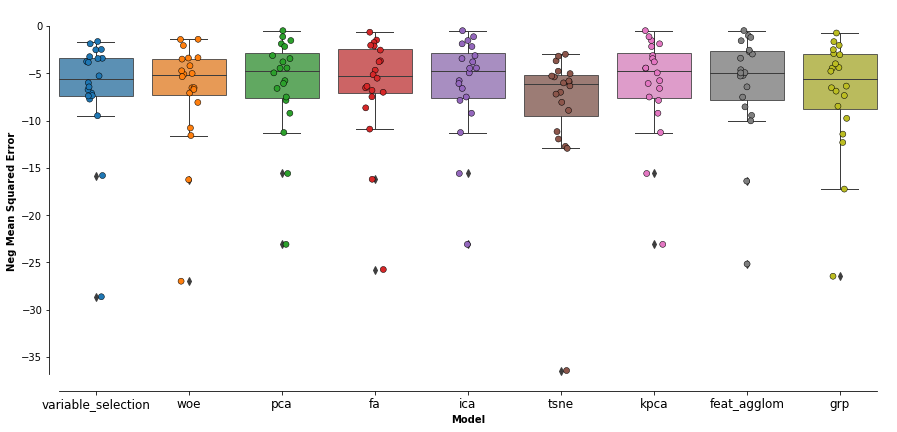

In [96]:
plt.figure(figsize = (15,7))
ax = sns.boxplot(x='model', y='neg_mean_squared_error', data=_,boxprops=dict(alpha=.8),linewidth=1)

sns.stripplot(x='model', y='neg_mean_squared_error', data=_, 
              size=6, jitter=True, edgecolor="black", linewidth=.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, fontsize =12) 
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
#plt.title(variable,  fontweight = "bold")
plt.xlabel('Model',  fontweight = "bold")
plt.ylabel('Neg Mean Squared Error',  fontweight = "bold")
plt.show()

# TMP utilizar variáveis de vif

In [110]:
df_2 = pd.concat([df_01T[target], df_01T[[col + '_01T' for col in vif_selected_variables]]], axis = 1)

In [126]:
import random

def generate_artificial(centroids_df, df_to_clust, percent, scaler,seed):
    random.seed(seed)
    columns = centroids_df.columns.values
    columns = np.append(columns, 'cluster')
    artificial_points = pd.DataFrame(columns = columns)
    
    for j in range(len(centroids_df)):
    
        rows = int(len(df_to_clust.loc[df_to_clust['cluster_labels'] == j])*percent)

        for x in range(rows):

            list1 = centroids_df.iloc[j].values
            list2 = df_to_clust.loc[df_to_clust['cluster_labels'] == j].iloc[x]
            point = []
            for i in range(len(list1)):             
                point.append(random.uniform(list1[i], list2[i]))
            point.append(j)
            artificial_points.loc[len(artificial_points)] = point

        artificial_points['cluster'] = artificial_points['cluster'].astype(int)
        
        variables = ['gender', 'year_collect']
        try:
            for variable in variables:
                counter = 0
                while counter < len(centroids_df):
                    mode = stats.mode(df_to_clust.loc[df_to_clust['cluster_labels'] == counter, variable].values)[0]
                    artificial_points.loc[artificial_points['cluster'] == counter, variable] = mode
                    counter +=1
        

            artificial_points['gender'] = artificial_points['gender'].astype(int)
        except:
            pass
    df_to_clust.drop(columns = 'cluster_labels',inplace=True)
    artificial_points.drop(columns = 'cluster',inplace=True)
    
    reverse_scaling = pd.DataFrame(scaler.inverse_transform(artificial_points),
                                   columns = artificial_points.columns,
                                   index = artificial_points.index)
        
    
    artificial_df = artificial_points.drop(columns = 'alcopops')

    artificial_df = pd.concat([reverse_scaling['alcopops'],artificial_df], axis = 1)
    
        
    return artificial_df

In [127]:
def get_artificial_df(n_clusters, df, percent ,seed):
    
    df_to_clust = df.copy()
    scaler = MinMaxScaler()
    df_to_clust = scaler.fit_transform(df_to_clust)
    df_to_clust=pd.DataFrame(df_to_clust, columns =  df.columns)
    
    cluster_range = range(1,n_clusters+1)
    cluster_errors = []
    sse = {}
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, 
                    random_state=seed,
                    n_init = 10,
                    max_iter = 300).fit(df_to_clust)
        sse[k] = kmeans.inertia_
        cluster_errors.append(kmeans.inertia_)

    df_to_clust["cluster_labels"] = kmeans.labels_
    centroids_df = pd.DataFrame(kmeans.cluster_centers_,columns=df_to_clust.drop(columns = ['cluster_labels']).columns)
    
    artificial_df = generate_artificial(centroids_df, df_to_clust, percent, scaler ,seed)
    
    
    return artificial_df

In [128]:
def artificial_concat(scaled_df, artificial_df):
    return pd.concat([scaled_df,artificial_df], axis = 0)

In [129]:
# Scale original data
scaler = MinMaxScaler()
x = scaler.fit_transform(df_2.drop(columns = target))
x = pd.DataFrame(x, columns = df_2.drop(columns = target).columns, index = df_2.drop(columns = target).index)
y = df_2[target]

scaled_df = pd.concat([y, x], axis = 1)

In [142]:
from sklearn.cluster import KMeans
artificial_vs_original = {'original': scaled_df.copy(),
                          'art_5c_100prop':artificial_concat(scaled_df, get_artificial_df(5, df_2, 1, seed)),
                          'art_10c_100prop':artificial_concat(scaled_df, get_artificial_df(10, df_2, 1, seed)),
                          'art_15c_100prop':artificial_concat(scaled_df, get_artificial_df(15, df_2, 1, seed)),
                          'art_5c_80prop':artificial_concat(scaled_df, get_artificial_df(5, df_2, 0.8, seed)),
                          'art_10c_80prop':artificial_concat(scaled_df, get_artificial_df(10, df_2, 0.8, seed)),
                          'art_15c_80prop':artificial_concat(scaled_df, get_artificial_df(15, df_2, 0.8, seed)),
                          'art_5c_50prop':artificial_concat(scaled_df, get_artificial_df(5, df_2, 0.5, seed)),
                          'art_10c_50prop':artificial_concat(scaled_df, get_artificial_df(10, df_2, 0.5, seed)),
                          'art_15c_50prop':artificial_concat(scaled_df, get_artificial_df(15, df_2, 0.5, seed))}

In [143]:
CV = 100
entries = []
l=pd.DataFrame()

for key, df_ in artificial_vs_original.items():
    x_train = df_.drop(columns = target)
    y_train = df_[target]

    accuracies = cross_val_score(LinearRegression(), x_train, y_train, scoring='neg_mean_squared_error', cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((key, fold_idx, accuracy))

In [144]:
df_pred = pd.DataFrame(entries, columns=['df', 'fold_idx', 'error'])
df_pred_grouped = pd.DataFrame(df_pred.groupby('df')['error'].agg('mean'))
df_pred_grouped.sort_values(by = 'error', ascending = False, inplace = True)
df_pred_grouped

,error
df,
art_5c_100prop,-4.227503
art_5c_80prop,-4.313891
art_15c_80prop,-4.804922
art_15c_100prop,-4.835193
art_10c_80prop,-4.841444
art_5c_50prop,-4.843213
art_10c_100prop,-5.004572
art_10c_50prop,-5.072195
art_15c_50prop,-5.244537


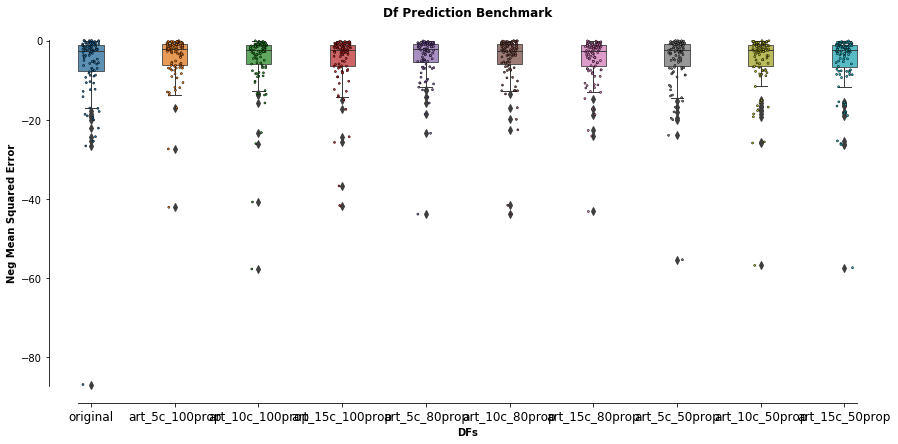

In [145]:
plt.figure(figsize = (15,7))
ax = sns.boxplot(x='df', y='error', data=df_pred,boxprops=dict(alpha=.8),linewidth=1, width = 0.3)
sns.stripplot(x='df', y='error', data=df_pred, 
              size=2, jitter=True, edgecolor="black", linewidth=.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, fontsize =12) 
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
plt.title('Df Prediction Benchmark',  fontweight = "bold")
plt.xlabel('DFs',  fontweight = "bold")
plt.ylabel('Neg Mean Squared Error',  fontweight = "bold")
plt.show()

# Teste estatístico

In [302]:
from scipy import stats

In [303]:
# select best decomposition/selection technique

best_way = comparing_eng.index[0]
t1 = _.loc[_.method == best_way]['neg_mean_squared_error']

# compare with variable selection
t2 = _.loc[_.method == 'variable_selection']['neg_mean_squared_error']
print(stats.ttest_ind(a, b))

Ttest_indResult(statistic=-0.25597799594988063, pvalue=0.7993484886438258)


In [304]:
#data.boxplot(column=['FSIQ','PIQ'])

stats.ttest_rel(t1, t2)  
# paired, pvalue > 0.05, accept null hypothesis
stats.wilcoxon(t1, t2)
# paired no gaussian assumption, pvalue > 0.05, accept null hypothesis
stats.ttest_1samp(t1, t2, 0)
# 1 sample t-test with difference, same result as stats.ttest_rel

# one-tailed, greater than 't2'
results = stats.ttest_rel(t1, t2) 
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print ("reject null hypothesis, mean of {} is greater than mean of {}".format('t1','t2'))
else:
    print ("accept null hypothesis")
    
# one-tailed, less than 't1
results = stats.ttest_rel(t1, t2) 
alpha = 0.05
if (results[0] < 0) & (results[1]/2 < alpha):
    print ("reject null hypothesis, mean of {} is less than mean of {}".format('t1','t2'))
else:
    print ("accept null hypothesis")

accept null hypothesis
accept null hypothesis


# Export df

In [97]:
# Scale

scaler = MinMaxScaler()
scaler.fit(df.drop(columns = target))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [98]:
x_test = pd.DataFrame(scaler.transform(df_test.drop(columns = target)), index = df_test.index, columns = df_test.drop(columns = target).columns)
y_test = df_test[target]

In [99]:
kpca_test = pd.DataFrame(kpca.transform(x_test), index = x_test.index, columns = kpca_names)
kpca_test = pd.concat([kpca_test, y_test], axis = 1)

In [100]:
kpca_df.head()

,KPCA1,KPCA2,KPCA3,KPCA4,KPCA5,KPCA6,alcopops
0,-0.583973,-0.564551,-0.743522,0.019991,0.027373,0.080056,2.3
1,0.632424,-0.700055,-0.744277,0.399942,0.280927,0.185234,0.9
2,-0.653598,-0.611485,-0.029396,0.089670,0.154031,0.181141,4.4
3,0.470800,-0.570204,-0.043618,0.046915,0.082674,0.199172,3.6
6,-0.397828,-0.556061,0.644815,-0.218691,0.053185,-0.152688,1.8


In [101]:
kpca_test.head()

,KPCA1,KPCA2,KPCA3,KPCA4,KPCA5,KPCA6,alcopops
64,-0.607576,-0.492339,-0.154648,-0.124475,0.154219,0.455733,6.7
63,0.644722,-0.317519,-0.441797,-0.373253,0.140321,-0.000944,0.7
55,0.580063,-0.355224,-0.273190,-0.489799,0.138784,0.232197,1.2
111,0.502573,0.533134,-0.126894,0.101087,0.189250,0.095141,5.8
225,0.440815,0.117757,-0.088534,-0.242539,-0.253978,0.317679,3.3


In [326]:
# Extract step 02 to excel
kpca_df.to_excel("df_02.xlsx")
kpca_test.to_excel('df_test_02.xlsx')